Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [3]:
# Run this cell if you are using Google Colab
%%capture
! pip install hmmlearn
! pip install mne

In [15]:
import mne
import numpy as np
from sklearn.decomposition import PCA
from hmmlearn import hmm
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [16]:

def embedx(x, lags):
    """Embeds a [samples * channels] array X using a vector of time lags
    resulting in a [channels * samples * lags] array xe.
    
    Parameters
    ----------
    x : array
        Input data [channels x samples].
    lags : list
        The desired lags.

    Return
    ------
    xe : array
        The embedded data [channels, samples, lags]. xe contains
        only the valid subsection of the orignal data, after edge
        effects have been removed.
    valid : array
        Boolean array indexing the valid samples in xe.
    """
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


def hmm_tde(data: np.array, lags, n_states=3, n_components=8, **kwargs):
    """Time-delay embedded Hidden markov model.

    Adapted from the HMM-MAR toolbox [3].

    Parameters
    ----------
    data : array
        Observations [channels * samples].
    lags : array | list
        Sample lags.
    n_states : int
        Number of states.
    n_components : int
        Number of components for the PCQ decomposition.

    Return
    ------
    gamma : array
        Time courses of the states probabilities given data.
    model : hmmlearn object.
        Hidden Markov Model.
    xe : array
        Embedded data [channels * samples * lags]

    References
    ----------
    [1] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G., Nowak, M., Seedat,
        Z. A., … Woolrich, M. W. (2019). Unpacking Transient Event Dynamics in
        Electrophysiological Power Spectra. Brain Topography, 32(6), 1020–1034.
        https://doi.org/10.1007/s10548-019-00745-5

    [2] Vidaurre, D., Hunt, L. T., Quinn, A. J., Hunt, B. A. E., Brookes, M. J.,
        Nobre, A. C., & Woolrich, M. W. (2018). Spontaneous cortical activity
        transiently organises into frequency specific phase-coupling networks.
        Nature Communications, 9(1). https://doi.org/10.1038/s41467-018-05316-z

    [3] https://github.com/OHBA-analysis/HMM-MAR
    """

    # Embed time serie
    xe, valid = embedx(data, lags)

    pca = PCA(n_components=n_components)
    y = pca.fit_transform(xe[0, :, :])

    model = hmm.GaussianHMM(n_components=n_states, n_iter=100,
                            covariance_type='full', **kwargs)
    model.fit(y)
    gamma = model.predict_proba(y)
    
    return gamma, model, xe

# Simulate EEG signal

In [11]:
def simulate_single_channel(
    mode: str = 'short', sfreq: int = 256, seconds: float = 10.0,
    f1: float = 25.0, f2: float = 40.0, seed: int = 123
    )-> np.array:
    """Generate time serie with high-frequency bursts.

    Adapted from [1, 2].

    Parameters
    ----------
    mode : str
        Length of the simulation (`'short'` or `'long'`). If `'long'` is selected,
        the simulation is extended to eight times its lenght. Burst patterns
        are repeated in time but the noise is not. Default is set to `'short'`.
    sfreq : int
        Sampling frequency. Default is set to 256 Hz.
    seconds : int
        Length of recording. If mode is set to ´'long'´, this will be multiplied by 8.
    f1, f2 : int
        Frequency of the first and second burst (Hz).

    Return
    ------
    x : numpy.array
        Array containing the simulation.

    References
    ----------
    [1] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G.,
        Nowak, M., Seedat, Z. A., … Woolrich, M. W. (2019). Unpacking
        Transient Event Dynamics in Electrophysiological Power Spectra.
        Brain Topography, 32(6), 1020–1034. https://doi.org/10.1007/s10548-019-00745-5

    [2] https://github.com/OHBA-analysis/Quinn2019_BurstHMM/blob/master/hmm_util_get_simulation.m
    """

    # A noise time-course is created by direct pole-placement. This creates 
    # a filter with an approximately 1/f frequency profile.
    time_vect = np.linspace(0, seconds, seconds*sfreq)

    # the value in poly is the filter root. it can vary between 0 < x < 1 where 0
    # is white noise and 1 is an extremely sloped spectrum
    # a is then the denominator polynomial of a digital filter which is used to
    # create the signal
    noise = np.random.random(len(time_vect))
    b, a = signal.butter(1, 0.5)
    x = signal.filtfilt(b, a, noise)

    # Define burst occurances and durations
    seconds = 10
    np.random.seed(seed)
    starts = np.sort(
        np.round(np.array([0.1, 0.3, 0.6, 0.9]) * (seconds/2) * sfreq)).astype(int)
    starts2 = (starts + (seconds/2 * sfreq)).astype(int)
    duration = np.round((np.random.random(4) + 0.1) * sfreq).astype(int)

    # Create burst time-courses
    x2 = np.zeros(seconds*sfreq)
    x3 = np.zeros(seconds*sfreq)

    for st, dur in zip(starts, duration):
        # Add slow burst
        tmp = np.sin(2*np.pi*f1*time_vect[st:st+dur])
        tmp = tmp * signal.tukey(len(tmp), alpha=.25)
        x2[st:st+dur] = x2[st:st+dur] + tmp

    for st, dur in zip(starts2, duration):
        # Add fast burst
        tmp = np.sin(2*np.pi*f2*time_vect[st:st+dur])
        tmp = tmp * signal.tukey(len(tmp), alpha=.25)
        x3[st:st+dur] = x3[st:st+dur] + tmp

    # sum the noise and burst time-courses to create the final simulation
    amp2 = .3
    amp3 = .3

    if mode == 'long':
        # Extend simulation to eight times its lenght
        # Burst patterns are repeated in time but the noise is not
        noise = np.random.random(len(time_vect) * 8)
        x = signal.filtfilt(b, a, noise)
        x2 = np.tile(amp2 * x2, (1, 8))
        x3 = np.tile(amp3 * x3, (1, 8))
        time_vect = np.linspace(0, seconds * 8, seconds * sfreq * 8)

    elif mode == 'short':
        # Return short form of simulation
        noise = np.random.random(len(time_vect))
        x = signal.filtfilt(b, a, noise)
        x2 = np.tile(amp2 * x2, (1, 1))
        x3 = np.tile(amp3 * x3, (1, 1))
    else:
        raise ValueError('Mode should be ´short´ or ´long´')

    data = x + x2 + x3

    # Concatenate different parts of simulation
    x = np.vstack([data, x2[0, :], x3[0, :]])

    return x

# Embedded Hidden Markov Model inference

In [17]:
sfreq, seconds = 256, 10
x = simulate_single_channel('long', sfreq=sfreq, seconds=seconds)
data = x[0, :].reshape(-1, 1)
lags = np.arange(-11, 11)

Here we use a time-delay embedded Hidden Markov Model described in [1].

In [18]:
gamma, model, xe = hmm_tde(data, lags, n_states=3, n_components=4)
time = np.arange(0, len(gamma[:, 0])/256, 1/256)

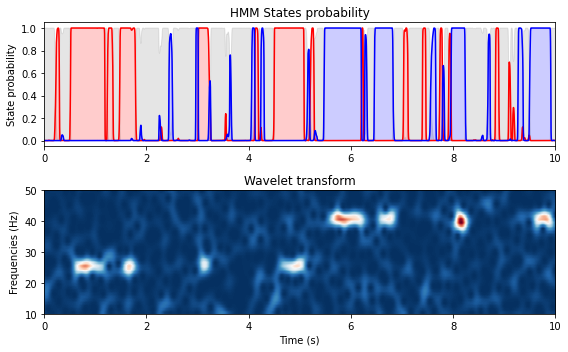

In [19]:
plt.figure(figsize=(8, 5))
plt.subplot(211)
plt.title('HMM States probability')

# plot noise state
noise = np.argmax(np.mean(gamma, 0))
plt.fill_between(x=time, y1=gamma[:, noise], alpha=.2, color='gray')

states = np.where([i not in [noise] for i in range(3)])[0]
for i, col in zip(states, ['r', 'b']):
    plt.plot(time, gamma[:, i], col)
    plt.fill_between(x=time, y1=gamma[:, i], alpha=0.2, color=col)
    plt.xlim(0, 10)
plt.ylabel('State probability')

# Time-frequency plot
plt.subplot(212)

# Use MNE to extract TFR
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['misc'])
raw = mne.EpochsArray(x.reshape(1, -1)[np.newaxis, :, :], info, verbose=False)
freqs, n_cycles = np.arange(10, 50), np.arange(10, 50)/2
tfr = mne.time_frequency.tfr_morlet(raw, freqs=freqs, n_cycles=n_cycles, picks='misc', return_itc=False)

plt.title('Wavelet transform')
plt.imshow(tfr._data[0][:, :10*256], aspect='auto', origin='lower', extent=[0, 10, 10, 50], cmap='RdBu_r')
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.tight_layout()
plt.savefig('tde-hmm.png', dpi=600)

# States spectral information

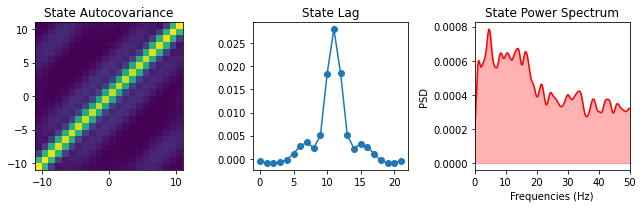

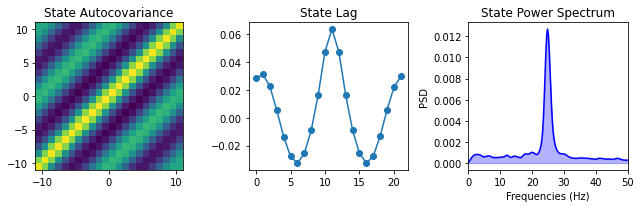

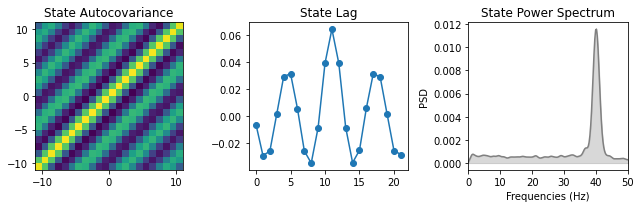

In [20]:
for i, col in zip(range(3), ['r', 'b', 'gray']):

    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.title('State Autocovariance')
    plt.imshow(np.cov(xe[0, gamma[:, i]> .5, :].T), origin='lower', extent=[-11, 11, -11, 11])

    plt.subplot(132)
    plt.title('State Lag')
    x = np.cov(xe[0, gamma[:, i]> .5, :].T)[11, :]
    plt.plot(x, 'o-')
    
    plt.subplot(133)
    plt.title('State Power Spectrum')
    
    # Compute PSD separately for each lag
    tot = []
    for seg in xe[0, gamma[:, i]> .5, :].T:
        freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
        tot.append(psd)
    psd = np.mean(np.asarray(tot), 0)
    
    plt.plot(freqs, psd, col)
    plt.fill_between(x=freqs, y1=psd, color=col, alpha=0.3)
    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.tight_layout()   
    plt.savefig('Spectral' + str(i) + '.png', dpi=600)

# References

[1] Vidaurre, D., Hunt, L. T., Quinn, A. J., Hunt, B. A. E., Brookes, M. J., Nobre, A. C., & Woolrich, M. W. (2018). Spontaneous cortical activity transiently organises into frequency specific phase-coupling networks. Nature Communications, 9(1). https://doi.org/10.1038/s41467-018-05316-z

[2] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G., Nowak, M., Seedat, Z. A., … Woolrich, M. W. (2019). Unpacking Transient Event Dynamics in Electrophysiological Power Spectra. Brain Topography, 32(6), 1020–1034. https://doi.org/10.1007/s10548-019-00745-5